In [1]:
import torch
import warnings
import os
import wandb

warnings.simplefilter("ignore", UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset.data_loaders import dataset_for_deepar
from pytorch_forecasting import DeepAR

from pytorch_forecasting.metrics import NormalDistributionLoss
from inference.bayesian.utils import plot_forecast
from inference.inference import inference

c:\Users\mgphy\Anaconda3\envs\uncertainty_pf\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
config = {
            "dataset": "acea",
            "inference": "deepar",
            "num_iterations": 50,
            "num_samples": 100,
            "sweep": True,
            "plot": True
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
training, train_dataloader, val_dataloader, test_dataloader, horizon = dataset_for_deepar(config.dataset)

In [4]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [5]:
model = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=32,
    rnn_layers=2,
    loss=NormalDistributionLoss(),
    optimizer="Adam",
)

In [6]:
predictive, diagnostics = inference(config, model, None,
                                    X_train=train_dataloader, Y_train=None, 
                                    X_val=val_dataloader, Y_val=None,
                                    X_test=test_dataloader, Y_test=None,
                                    quantiles=quantiles,
                                    horizon=24,
                                    device=device)

AttributeError: 'NoneType' object has no attribute 'type'

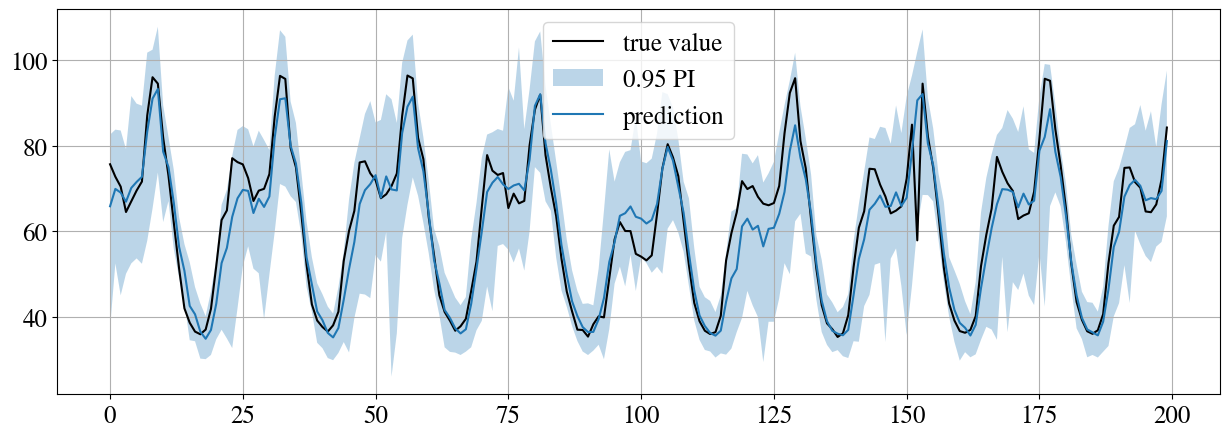

In [7]:
CI = [diagnostics["quantiles"][2], diagnostics["quantiles"][-2]]

plot_forecast(predictive, predictive["y"], None, np.zeros(shape=(predictive['obs'].shape[1])), CI, "deepar", 200)

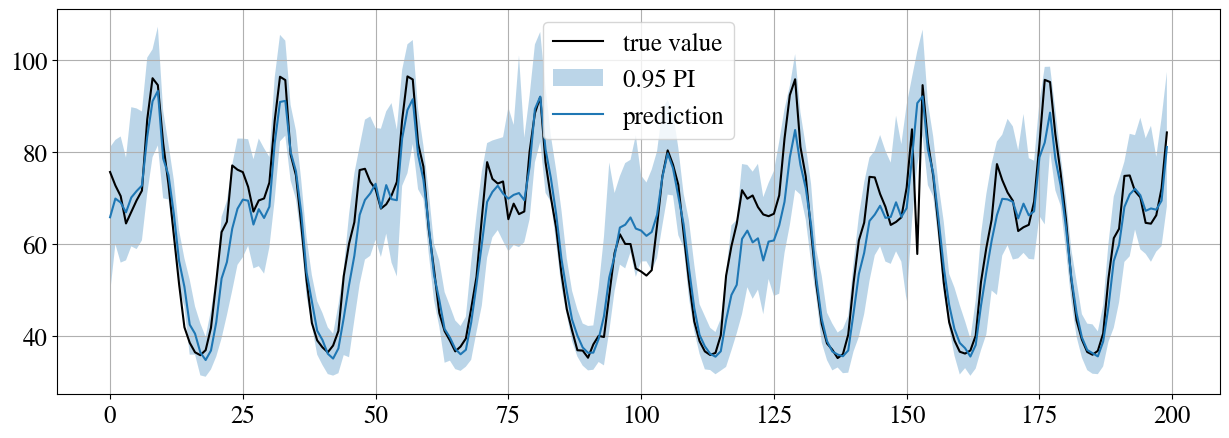

In [8]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, predictive["y"], None, np.zeros(shape=(predictive['obs'].shape[1])), CI, "deepar", 200)

In [9]:
for k, v in diagnostics.items():
    print(k, "\t", v)

train_time 	 4707.046875
final_loss 	 nan
inference_time 	 86.0625
cal_error 	 0.16303436917995504
new_cal_error 	 0.015639018525201803
quantiles 	 [0, 0.005, 0.025, 0.05, 0.07500000000000001, 0.1, 0.125, 0.15000000000000002, 0.17500000000000002, 0.2, 0.225, 0.25, 0.275, 0.30000000000000004, 0.325, 0.35000000000000003, 0.375, 0.4, 0.42500000000000004, 0.45, 0.47500000000000003, 0.5, 0.525, 0.55, 0.5750000000000001, 0.6000000000000001, 0.625, 0.65, 0.675, 0.7000000000000001, 0.7250000000000001, 0.75, 0.775, 0.8, 0.8250000000000001, 0.8500000000000001, 0.875, 0.9, 0.925, 0.9500000000000001, 0.9750000000000001, 0.995]
new_quantiles 	 [0.         0.         0.08053571 0.13509434 0.16836207 0.19486486
 0.22379032 0.25505882 0.27742424 0.30450617 0.32756579 0.35241935
 0.38131944 0.40607143 0.42868056 0.45463768 0.48042169 0.502875
 0.52578704 0.54296296 0.56033019 0.57788462 0.59572115 0.61424242
 0.63408046 0.6547     0.67325    0.6918     0.70932432 0.7261165
 0.74412621 0.76106195 0.7780